In [1]:
import os
os.chdir(r'C:\Users\82107\Desktop\Study\ML learning')
print('current directory:', os.getcwd())

current directory: C:\Users\82107\Desktop\Study\ML learning


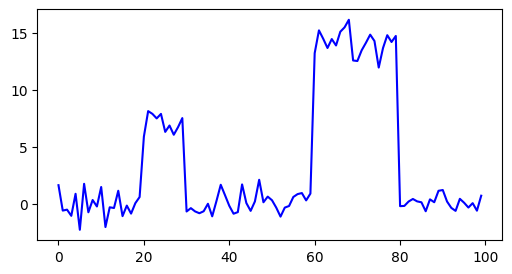

In [2]:
# 모형 적합에 사용할 데이터 생성
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
np.random.seed(1)
n = 100
y = np.random.normal(0, 1, n)
y[20:30] += 7
y[60:80] += 14
# 해당 타임 포인트에 평균이 7, 14인 곳을 인위적으로 만들어줌


# 시각화
plt.figure(figsize=(6, 3))
plt.plot(y, c='b')

In [4]:
# beta를 delta로 바꾸기위해 필요한 행렬
D = np.tril(np.ones((n, n-1)), k=-1)    # trill = 삼각행렬을 만들어준다, n-1 = 행렬을 왼쪽으로 한칸 땡겨준다(두번째 행부터 1로 시작)
D.shape

(100, 99)

In [5]:
D

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [8]:
# 특정한 alpha의 값에서 Fused Lasso 모형 적합과 delta 확인
a = 0.1     #초기 parameter
lasso = Lasso(alpha=a, fit_intercept=True)
lasso.fit(D, y)
delta = lasso.coef_     #coef는 beta가 아니라 delta에 관한 것임
delta.shape

(99,)

In [9]:
delta[:20]

array([-0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.22779895,  4.50396345])

In [10]:
lasso.intercept_

0.35524231746814205

In [11]:
# delta를 beta로 변환
beta_hat = np.cumsum(delta) + lasso.intercept_      # cumsum = 누적합
beta_hat[:20]

array([0.35524232, 0.35524232, 0.35524232, 0.35524232, 0.35524232,
       0.35524232, 0.35524232, 0.35524232, 0.35524232, 0.35524232,
       0.35524232, 0.35524232, 0.35524232, 0.35524232, 0.35524232,
       0.35524232, 0.35524232, 0.35524232, 0.58304127, 5.08700472])

(-4.95, 103.95, -3.225894402050955, 17.109931111703833)

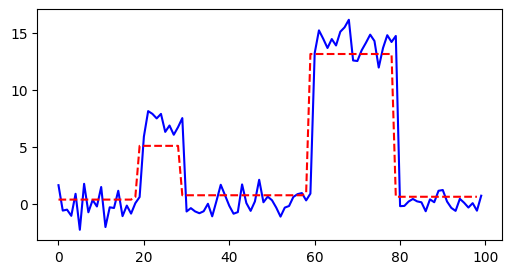

In [12]:
# 시각화
plt.figure(figsize=(6, 3))
plt.plot(y, c='b')
plt.plot(beta_hat, c='r', linestyle='--')
plt.axis('tight')
#파란 선은 Yt(실제 값), 빨간 선은 예측값(Beta)

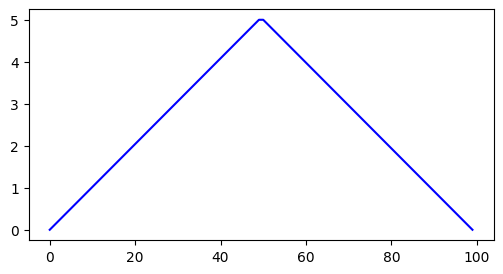

In [13]:
#Trend-filtering
# True model 생성

n = 100
true_trend = np.linspace(0,5,int(n/2))
true_trend = np.append(true_trend, np.linspace(5,0,int(n/2)))
# 시각화
plt.figure(figsize=(6, 3))
plt.plot(true_trend, c='b')

In [14]:
# 관측된 데이터 생성
np.random.seed(1000)
y = true_trend + np.random.normal(0, 1, n)  #true trend에 정규분포만큼의 값을 노이즈로 더해줌
y = y.reshape((n, 1))
y[:10, :]       #이 Yi를 보고 True trend를 알아내야함

array([[-0.8044583 ],
       [ 0.42297236],
       [ 0.17859875],
       [ 0.95044628],
       [ 0.10736659],
       [ 0.89967864],
       [ 0.5048076 ],
       [ 0.23430264],
       [ 1.41136203],
       [ 0.45369982]])

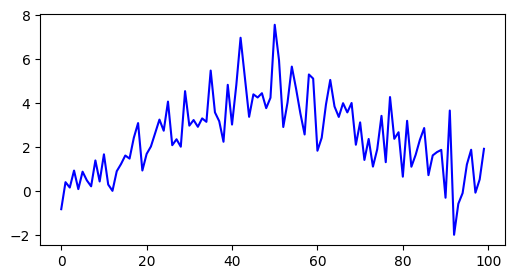

In [15]:
# 시각화
plt.figure(figsize=(6, 3))
plt.plot(y, c='b')  

In [16]:
# parameter 설정
rho = 1
l = 5
D = (np.eye(n) + np.diag([-2]*(n-1), k=1) + np.diag([1]*(n-2), k=2))[:-2, :]    #일반화 Lasso에서 사용되는 D행렬
D.shape


(98, 100)

In [18]:
D

array([[ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.]])

In [20]:
# initial value
beta = np.ones((n ,1))  #실제로 우리가 구하고자 하는 변수
z = np.ones((n-2 ,1))   #ADMM을 위해서 도입한 변수
mu = np.ones((n-2, 1))

# ADMM의 일부분
# beta update
beta = np.linalg.inv((rho/2) * D.T @ D + np.eye(n)) @ (y - D.T @ (mu - rho*z)/2)
beta[:6, :]


array([[-0.61103576],
       [ 0.09256634],
       [ 0.40932335],
       [ 0.61320225],
       [ 0.51672081],
       [ 0.60688486]])

In [21]:
# z update
z_temp = D @ beta + mu/rho
for i in range(n-2):
    if z_temp[i] < -l/rho:
        z[i] = z_temp[i] + l/rho
    elif z_temp[i] > l/rho:
        z[i] = z_temp[i] - l/rho
    else:
        z[i] = 0
z[:6, :]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [22]:
# mu update
mu = mu + rho*(D @ beta - z)
mu[:6, :]

array([[0.61315492],
       [0.88712189],
       [0.69963966],
       [1.18664549],
       [0.85494289],
       [1.10882783]])

In [23]:
# parameter 설정
rho = 1
l = 5
D = (np.eye(n) + np.diag([-2]*(n-1), k=1) + np.diag([1]*(n-2), k=2))[:-2, :]
# initial value
beta = np.ones((n ,1))
z = np.ones((n-2 ,1))
mu = np.ones((n-2, 1))
# ADMM
for k in range(2000):
    # beta update
    beta = np.linalg.inv((rho/2) * D.T @ D + np.eye(n)) @ (y - D.T @ (mu - rho*z)/2)
    # z update
    z_temp = D @ beta + mu/rho
    for i in range(n-2):
        if z_temp[i] < -l/rho:
            z[i] = z_temp[i] + l/rho
        elif z_temp[i] > l/rho:
            z[i] = z_temp[i] - l/rho
        else:
            z[i] = 0
    # mu update
    mu = mu + rho*(D @ beta - z)      

(-4.95, 103.95, -2.4444100296290387, 8.05186249008904)

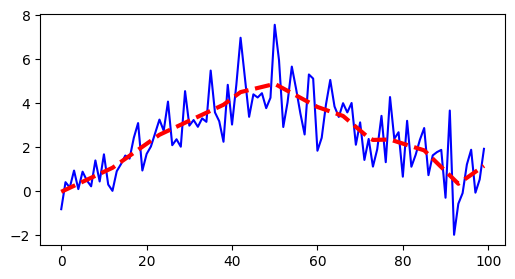

In [24]:
# 시각화
plt.figure(figsize=(6, 3))
plt.plot(y, c='b')
plt.plot(beta, c='r', linestyle='--', linewidth=3)
plt.axis('tight')
#빨간선의 Beta hat을 얻어낼 수 있다